In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from math import ceil
from pipeline_func import create_and_fit_decision_tree, calculate_prediction, calculate_accuracy, create_submission, store_accuracy_results

# temporary files: /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# read data and check for null

dt = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print("Nulls found in: ")
print('-- train data')
dt.head()
dt.describe()
print(dt.loc[:,dt.isnull().any()].columns)

print('-- test data')
print(test.loc[:,test.isnull().any()].columns)

Nulls found in: 
-- train data
Index(['Age', 'Cabin', 'Embarked'], dtype='object')
-- test data
Index(['Age', 'Fare', 'Cabin'], dtype='object')


In [3]:
# code category into binary var
gender = {'male': 0, 'female': 1}
dt['Sex_bin'] = pd.DataFrame([gender[g] for g in dt.Sex])
test['Sex_bin'] = pd.DataFrame([gender[g] for g in test.Sex])

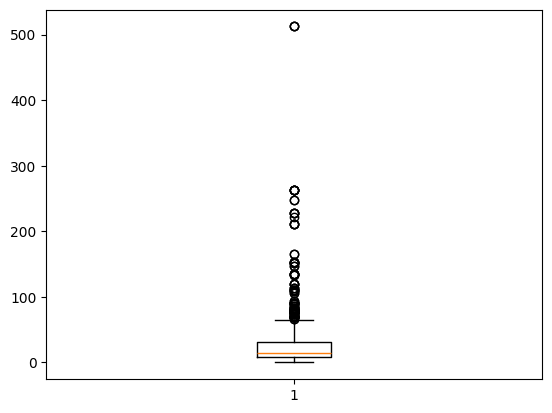

512.3292
Lower whisker:  0.0
Upper whisker:  65.0


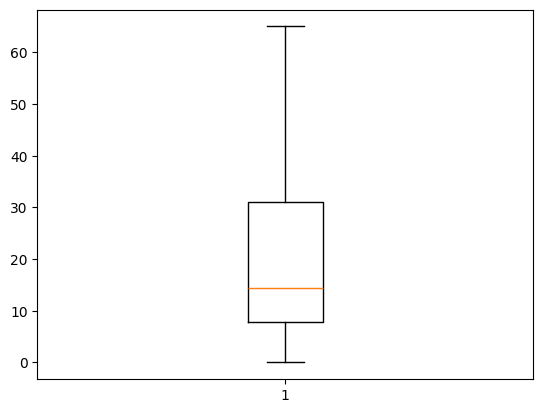

In [4]:
### handling fare outliers
# find lower and upper whisker of a boxplot (representing min and max of middle 50% interval)
plt.boxplot(dt.Fare)
plt.show()

# q1 = train.Fare.quantile(0.25)
# q3 = train.Fare.quantile(0.75)
# low_whisker = train.Fare[train.Fare >= q1 - 1.5*(q3-q1)].min()
# upp_whisker = train.Fare[train.Fare <= q3 + 1.5*(q3-q1)].max()

def remove_outliers(df, feature):
    feature_boxplot = plt.boxplot(df[feature])
    plt.close()

    [low_whisker, upp_whisker] = [item.get_ydata()[1] for item in feature_boxplot['whiskers']]
    print("Lower whisker: ", low_whisker)
    print("Upper whisker: ", upp_whisker)

    # create new column with replaced values
    df[feature+'_wt_outliers'] = df[feature]
    df.loc[df[feature+'_wt_outliers'] < low_whisker, feature+'_wt_outliers'] = low_whisker
    df.loc[df[feature+'_wt_outliers'] > upp_whisker, feature+'_wt_outliers'] = upp_whisker
    
    return df

print(dt.Fare.max())
dt = remove_outliers(dt, 'Fare')
plt.boxplot(dt.Fare_wt_outliers)
plt.show()


{1: 60.0, 2: 15.75, 3: 7.8958}


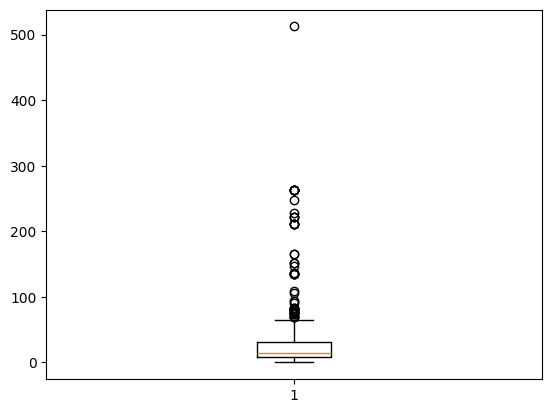

Lower whisker:  0.0
Upper whisker:  65.0


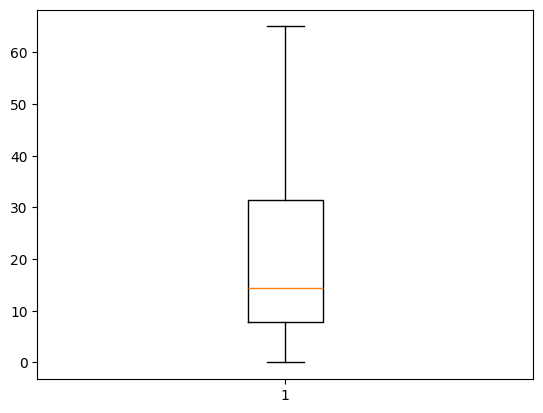

In [5]:
### handling fare outliers on test set

# there are missing values in test set - filling missing values with the median within given Pclass
# filling done separately on test set (we do not want to influence test set with training and vice versa)

# calculate median fare value by class
mean_fare_by_pclass = test.groupby(by='Pclass').median(numeric_only=True).Fare.to_dict()
# replace null values
print(mean_fare_by_pclass)
test['Fare'] = test.Fare.fillna(test.Pclass.map(mean_fare_by_pclass)) # consider keeping this feature under new name 

plt.boxplot(test.Fare)
plt.show()

test = remove_outliers(test,'Fare')
plt.boxplot(test.Fare_wt_outliers)
plt.show()

### 0 is probably also a missing data here


In [6]:
# split dt into train and validation sets
train = dt.sample(frac=0.8, random_state=0)
validation = dt.drop(train.index)

len(train) + len(validation) == len(dt)

True

In [7]:
# store accuracy results for each model
accuracy_results = pd.DataFrame(columns=['model', 'features', 'train_acc', 'validation_acc', 'test_acc'])

In [8]:
# pipeline
def run_dt(train, validation, X, Y, criterion, show_plot=True):
    # create and train the tree
    model = create_and_fit_decision_tree(train, X, Y, criterion, show_plot)

    # create prediction on train and validation sets
    train_predict = calculate_prediction(model, train, X)
    validation_predict = calculate_prediction(model, validation, X)

    # print accuracy of the prediction
    train_acc = calculate_accuracy("Train", train[Y], train_predict)
    validation_acc = calculate_accuracy("Validation", validation[Y], validation_predict)
    
    return model, train_acc, validation_acc

The plot below presents the correlation between features. It helps to identify the potential features helpful for training the model as well as observing where the same information might be brought by different features (e.g. Fare is correlated with Pclass)

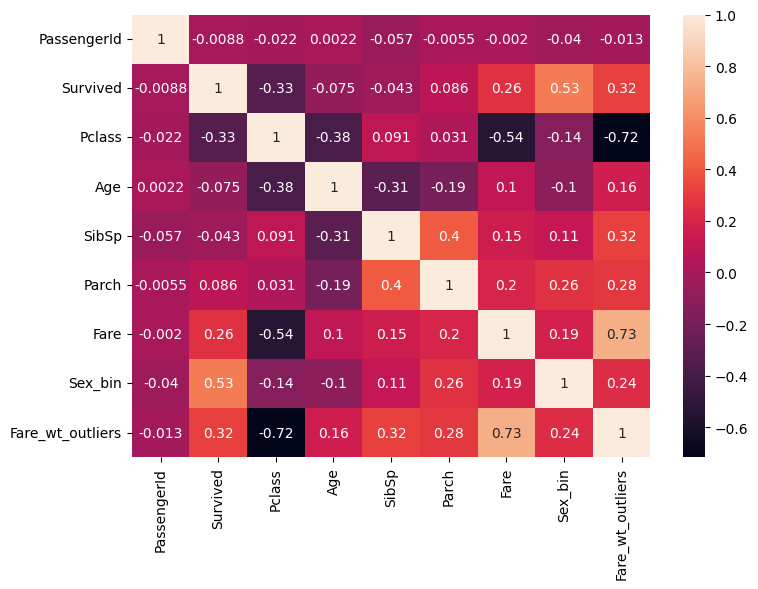

In [9]:
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(numeric_only=True), annot=True)
plt.tight_layout()

# Decision Tree 1

Features: Sex_bin

Criterion: Gini impurity

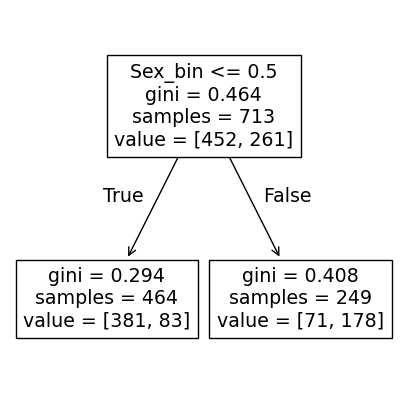

Train :  559.0  correctly classified samples -  78.4 %
Validation :  142.0  correctly classified samples -  79.78 %


In [10]:
X1 = ['Sex_bin']
Y = 'Survived'
criterion = "gini"

dtree1, train_acc1, validation_acc1 = run_dt(train, validation, X1, Y, criterion)
# value array tells how many samples fall into each to-be-predicted category (value = [549, 342] means that
# there are 549 0s and 342 1s)
# gini index drops with the division of the node -> good
subm1 = create_submission(dtree1, test, X1)
subm1.to_csv('./../output/submission1.csv', index=False)
# test submission on Kaggle resulted in 0.76555

# store accuracy
accuracy_results = store_accuracy_results(accuracy_results, 'dtree1', X1, train_acc1, validation_acc1, test_acc=0.76555)

## Gini index

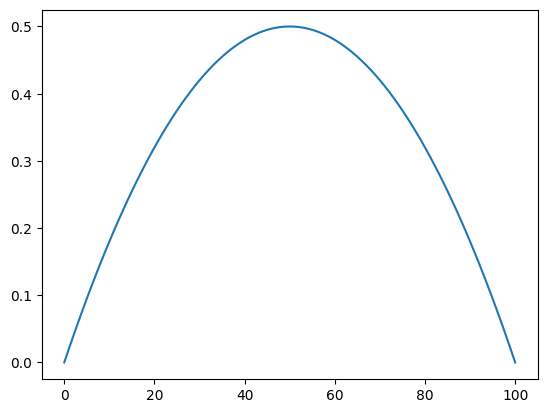

In [11]:
###  Gini index - visualization on dummy data
n = 100
# create 101 classes of different proportions of 0s and 1s
classes = pd.DataFrame(data=np.zeros(shape=(n,n+1)),columns = ['c'+str(k) for k in range(n+1)])
for k in range(1,n+1):
    classes['c'+str(k)].iloc[0:k] = 1
# print(classes)
cnt = classes.sum()

# calculate prob of 0 and 1 for each node
probs_0 = [(n-c)/n for c in cnt]
probs_1 = [c/n for c in cnt]

# Gini formula for node (class) with given no of 0s and 1s = 1-(P(0)^2+P(1)^2), 
# where P - probability function (based on frequency)
# In general, Gini formula for class c: G(c)= 1-sum{k in 1..n} P(k)^2, where n is number of different elements in class c

gini_index = [1 - (probs_0[k]**2 + probs_1[k]**2) for k in range(n+1)]
plt.plot(gini_index)

# The closer Gini index is to 0, the more purity we have in the node of the tree

# Decision Tree 2

Features: Sex_bin

Criterion: entropy

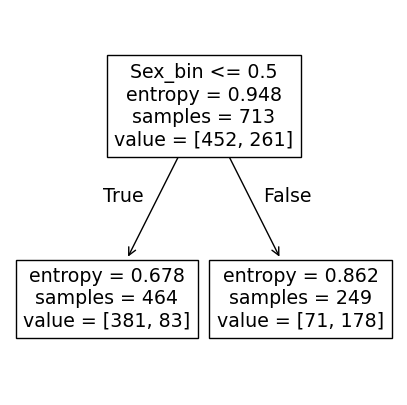

Train :  559.0  correctly classified samples -  78.4 %
Validation :  142.0  correctly classified samples -  79.78 %
True


In [12]:
X2 = ['Sex_bin']
Y = 'Survived'
criterion = "entropy"

dtree2, train_acc2, validation_acc2 = run_dt(train, validation, X2, Y, criterion)
subm2 = create_submission(dtree2, test, X2)
subm2.to_csv('./../output/submission2.csv', index=False)
print(all(subm2 == subm1))
# identical submission to subm1

accuracy_results = store_accuracy_results(accuracy_results, 'dtree2', X2, train_acc2, validation_acc2, test_acc=0.76555)

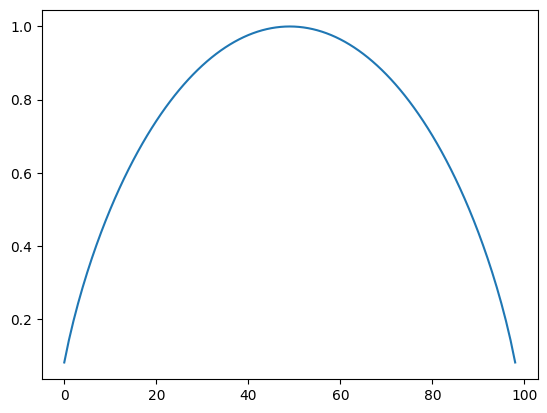

In [13]:
### entropy - visualization on dummy data
from math import log2

entropy = [-(probs_0[k]*log2(probs_0[k]) + probs_1[k]*log2(probs_1[k])) for k in range(1,n)] # for k=0 and k=n+1 log doesnt exist
plt.plot(entropy)

# Decision Tree 3

Features: Sex_bin, Pclass

Criterion: gini

In [14]:
# contingency table (crosstab)
sex_vs_pclass = pd.pivot_table(train, values='PassengerId', index='Sex', columns='Pclass', aggfunc='count')
sex_vs_pclass

Pclass,1,2,3
Sex,,,
female,74,59,116
male,96,83,285


In [15]:
import scipy.stats as stats

# chi-squared test statistic, sample size, and minimum of rows and columns
chi2, pval, _, _ = stats.chi2_contingency(sex_vs_pclass, correction=False)
# H0: there is no dependence between sex and pclass
# p = probability that the dependence is caused by random noise; if p<0.05, we can deny H0
print("p-value: ", pval)

# chi2 is affected by sample size and no of rows and columns 
# Cramer's V attempts to adjust for these
n = np.sum(sex_vs_pclass).sum() 
minDim = min(sex_vs_pclass.shape)-1 # no of degrees of freedom

# calculate Cramer's V - effect size measurement that tells how strong the relationship is
V = np.sqrt((chi2/n) / minDim)
print("Cramer's V: ", V)
# 0 - no correlation, 1 - strong correlation

# interpretation of Cramer's V depends on no of degrees of freedom
# there are many rules of thumb but in general for df=1 V=0.14 is pretty small

p-value:  0.0006667944244384896
Cramer's V:  0.1432250141596954


c:\Users\katar\python_envs\kaggle-titanic\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


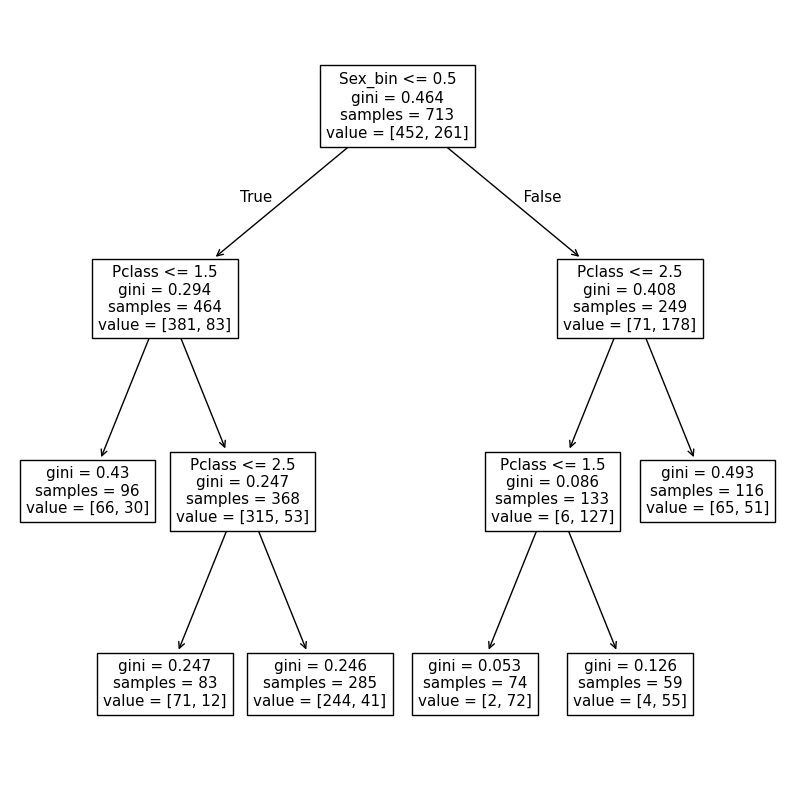

Train :  573.0  correctly classified samples -  80.36 %
Validation :  128.0  correctly classified samples -  71.91 %


In [16]:
X3 = ['Sex_bin', 'Pclass']
Y = 'Survived'
criterion = "gini"

dtree3, train_acc3, validation_acc3 = run_dt(train, validation, X3, Y, criterion)
subm3 = create_submission(dtree3, test, X3)
subm3.to_csv('./../output/submission3.csv', index=False)
# train fits better, validation worse - suggest overfitting
# test submission 0.77511 (only slightly better

accuracy_results = store_accuracy_results(accuracy_results, 'dtree3', X3, train_acc3, validation_acc3, test_acc=0.77511)

# Decision Tree 4

Features: Sex_bin, Pclass, Fare_wt_outliers

Criterion: gini

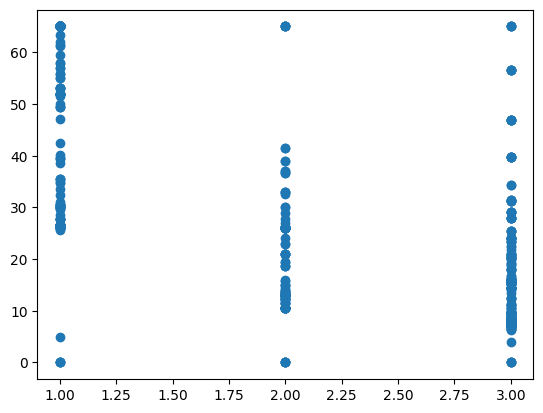

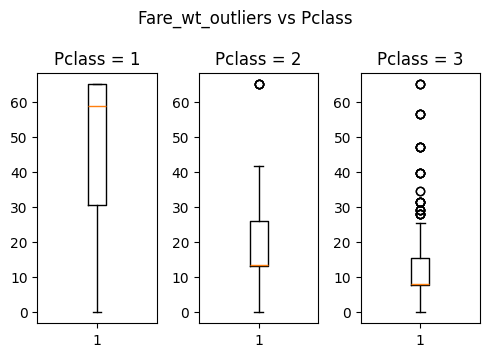

In [17]:
# plot Pclass vs Fare amount to see if there is any correspondence
plt.scatter(train.Pclass, train.Fare_wt_outliers)
plt.show()

# use boxplot to have more insight
# train[['Pclass','Fare']].boxplot(column='Fare',by='Pclass')

def plot_boxplot_grouped_by_another_col(data, col_to_plot, col_to_group_by):
    col_uniques = np.sort(data[col_to_group_by].unique())

    ncols = len(col_uniques) if len(col_uniques)<=5 else 5
    nrows = ceil(len(col_uniques)/5)

    fig, axes = plt.subplots(nrows, ncols, figsize=(nrows*5, ncols*1.2))
    fig.suptitle(col_to_plot + ' vs ' + col_to_group_by)

    for (ax, c) in zip(axes.reshape(-1,), col_uniques):
        ax.boxplot(x=data[col_to_plot][data[col_to_group_by]==c])
        ax.set_title(col_to_group_by + ' = ' + str(c))

    fig.tight_layout()
    plt.show()

plot_boxplot_grouped_by_another_col(train, 'Fare_wt_outliers', 'Pclass')
# Fare clearly depends on the Pclass, there are only few outliers

In [18]:
accuracy_results

,model,features,train_acc,validation_acc,test_acc
0,dtree1,[Sex_bin],0.784011,0.797753,0.76555
1,dtree2,[Sex_bin],0.784011,0.797753,0.76555
2,dtree3,"[Sex_bin, Pclass]",0.803647,0.719101,0.77511


In [19]:
# test if adding correlated information causes overfitting
X4 = ['Sex_bin', 'Pclass', 'Fare_wt_outliers']
Y = 'Survived'
criterion = "gini"

dtree4, train_acc4, validation_acc4 = run_dt(train, validation, X4, Y, criterion, show_plot=False)
subm4 = create_submission(dtree4, test, X4)
subm4.to_csv('./../output/submission4.csv', index=False)

# train and validation results a lot better (unexpected for validation), test result - worse (quite expected)
accuracy_results = store_accuracy_results(accuracy_results, 'dtree4', X4, train_acc4, validation_acc4, test_acc=0.77033)

Train :  639.0  correctly classified samples -  89.62 %
Validation :  142.0  correctly classified samples -  79.78 %


# Decision Tree 5

Features: Sex_bin, Fare

Criterion: gini

In [27]:
X5 = ['Sex_bin', 'Fare']
Y = 'Survived'
criterion = "gini"

dtree5, train_acc5, validation_acc5 = run_dt(train, validation, X5, Y, criterion, show_plot=False)
subm5 = create_submission(dtree5, test, X5)
subm5.to_csv('./../output/submission5.csv', index=False)


# train and validation results similar to dtree4, test result again worse
accuracy_results = store_accuracy_results(accuracy_results, 'dtree5', X5, train_acc5, validation_acc5, test_acc=0.76076)


Train :  647.0  correctly classified samples -  90.74 %
Validation :  142.0  correctly classified samples -  79.78 %


In [21]:
accuracy_results

,model,features,train_acc,validation_acc,test_acc
0,dtree1,[Sex_bin],0.784011,0.797753,0.76555
1,dtree2,[Sex_bin],0.784011,0.797753,0.76555
2,dtree3,"[Sex_bin, Pclass]",0.803647,0.719101,0.77511
3,dtree4,"[Sex_bin, Pclass, Fare_wt_outliers]",0.896213,0.797753,0.77033
4,dtree5,"[Sex_bin, Fare]",0.907433,0.797753,0.75837


# Decision Tree 6

Features: Sex_bin, Pclass, Fare w/t outliers

Criterion: gini

In [ ]:
X6 = ['Sex_bin', 'Pclass', 'Fare']
Y = 'Survived'
criterion = "gini"

dtree6, train_acc6, validation_acc6 = run_dt(train, validation, X6, Y, criterion, show_plot=False)
subm6 = create_submission(dtree6, test, X6)
subm6.to_csv('./../output/submission6.csv', index=False)

accuracy_results = store_accuracy_results(accuracy_results, 'dtree6', X6, train_acc6, validation_acc6, test_acc=0.76555)

Train :  648.0  correctly classified samples -  90.88 %
Validation :  143.0  correctly classified samples -  80.34 %


# Decision Tree 7

Features: Sex_bin, Pclass, Age

Criterion: gini

In [23]:
# display missing age data
train[train.Age.isnull()]

# we need to make missing age data imputation
# approach 1: IterativeImputer from sklearn

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder

print('Avg age mean: ', train.Age.mean())

imp_mean = IterativeImputer(random_state=0, min_value=0, max_value=train.Age.max())

# # encode Embarked categorical array into numerical -> tbf
# enc = OneHotEncoder()
# enc.fit_transform(train.Embarked.to_numpy().reshape(-1,1)).toarray()
# # ...
# X = ['Pclass', 'Sex_bin', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_num']

# what if we take only correlated data?

X = ['Pclass', 'Sex_bin', 'Age', 'SibSp', 'Parch', 'Fare']
train_transf = imp_mean.fit_transform(train[X].to_numpy())
train_transf = pd.DataFrame(train_transf, columns=X)
train['Age_suppl_i'] = train_transf.Age

# approach 2: mean value aggregated on categories

# titles
split_names = train.Name.str.split('[,|.]')
titles = [s[1].strip() for s in split_names]
train['Title'] = titles

# taken from some tutorial
title_dict = {"Capt": "Officer","Col": "Officer","Major": "Officer","Jonkheer": "Royalty", \
             "Don": "Royalty", "Sir" : "Royalty","Dr": "Royalty","Rev": "Royalty", \
             "the Countess":"Royalty", "Mme": "Mrs", "Mlle": "Miss", "Ms": "Mrs","Mr" : "Mr", \
             "Mrs" : "Mrs","Miss" : "Miss","Master" : "Master","Lady" : "Royalty"}

train['Title_unif'] = [title_dict[title] for title in titles]
train_wt_age_nan = train[~train.Age.isnull()]

#plot_boxplot_grouped_by_another_col(train_wt_age_nan, 'Age', 'Title_unif')

# calculate mean fare value by class
mean_age_by_title = train.groupby(by='Title_unif').mean(numeric_only=True).Age.to_dict()
# replace null values
print(mean_age_by_title)
train['Age_suppl_ii'] = train.Age.fillna(train.Title_unif.map(mean_age_by_title))
train.Age_suppl_ii.isnull().any()

train[['Age_suppl_i','Age_suppl_ii', "Age"]]
display(train.head(30))

# train.corr()


Avg age mean:  29.505356521739134
{'Master': 4.602666666666667, 'Miss': 21.297619047619047, 'Mr': 32.246875, 'Mrs': 36.8125, 'Officer': 56.6, 'Royalty': 42.642857142857146}


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_bin,Fare_wt_outliers,Age_suppl_i,Title,Title_unif,Age_suppl_ii
495,496,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C,0,14.4583,19.000000,Mr,Mr,32.246875
648,649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S,0,7.5500,19.000000,Mr,Mr,32.246875
278,279,0,3,"Rice, Master. Eric",male,7.00,4,1,382652,29.1250,NaN,Q,0,29.1250,24.739445,Master,Master,7.000000
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C,1,65.0000,50.000000,Mrs,Mrs,36.812500
255,256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.00,0,2,2650,15.2458,NaN,C,1,15.2458,18.000000,Mrs,Mrs,29.000000
298,299,1,1,"Saalfeld, Mr. Adolphe",male,NaN,0,0,19988,30.5000,C106,S,0,30.5000,45.000000,Mr,Mr,32.246875
609,610,1,1,"Shutes, Miss. Elizabeth W",female,40.00,0,0,PC 17582,153.4625,C125,S,1,65.0000,23.000000,Miss,Miss,40.000000
318,319,1,1,"Wick, Miss. Mary Natalie",female,31.00,0,2,36928,164.8667,C7,S,1,65.0000,0.000000,Miss,Miss,31.000000
484,485,1,1,"Bishop, Mr. Dickinson H",male,25.00,1,0,11967,91.0792,B49,C,0,65.0000,47.000000,Mr,Mr,25.000000
367,368,1,3,"Moussa, Mrs. (Mantoura Boulos)",female,NaN,0,0,2626,7.2292,NaN,C,1,7.2292,16.000000,Mrs,Mrs,36.812500


In [31]:
X7 = ['Sex_bin', 'Pclass', 'Age']
Y = 'Survived'
criterion = "gini"

dtree7, train_acc7, validation_acc7 = run_dt(train, validation, X7, Y, criterion, show_plot=False)
subm6 = create_submission(dtree7, test, X7)
subm6.to_csv('./../output/submission7.csv', index=False)

accuracy_results = store_accuracy_results(accuracy_results, 'dtree7', X7, train_acc7, validation_acc7, test_acc=0.74641)

Train :  632.0  correctly classified samples -  88.64 %
Validation :  139.0  correctly classified samples -  78.09 %


# Cross-validation

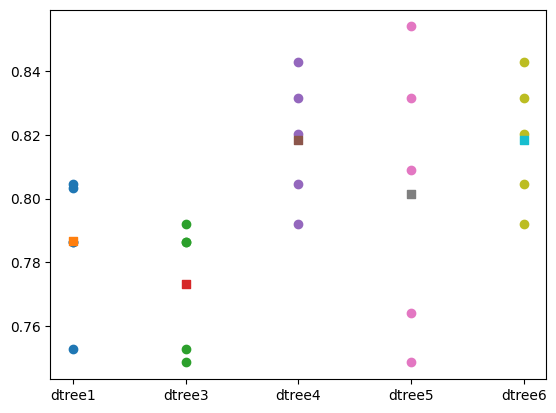

Average cv_score:
dtree1    0.786737
dtree3    0.773316
dtree4    0.818197
dtree5    0.801406
dtree6    0.818197
dtype: float64


In [ ]:
from sklearn.model_selection import cross_val_score
cv_score = {}
cv_no = 5
cv_score['dtree1'] = cross_val_score(dtree1, dt[X1], dt[Y], cv=cv_no)
cv_score['dtree3'] = cross_val_score(dtree3, dt[X3], dt[Y], cv=cv_no)
cv_score['dtree4'] = cross_val_score(dtree4, dt[X4], dt[Y], cv=cv_no)
cv_score['dtree5'] = cross_val_score(dtree5, dt[X5], dt[Y], cv=cv_no)
cv_score['dtree6'] = cross_val_score(dtree6, dt[X6], dt[Y], cv=cv_no)
cv_score['dtree7'] = cross_val_score(dtree7, dt[X7], dt[Y], cv=cv_no)

# plt.scatter(pd.DataFrame(cv_score))
cv_score = pd.DataFrame(cv_score)
for cv in cv_score.columns:
    plt.scatter([cv]*cv_no, cv_score[cv])
    plt.scatter(cv, cv_score[cv].mean(), marker='s')
plt.show()

print('Average cv_score:')
print(cv_score.mean())

In [25]:
accuracy_results
# highest accuracy for dtree6

,model,features,train_acc,validation_acc,test_acc
0,dtree1,[Sex_bin],0.784011,0.797753,0.76555
1,dtree2,[Sex_bin],0.784011,0.797753,0.76555
2,dtree3,"[Sex_bin, Pclass]",0.803647,0.719101,0.77511
3,dtree4,"[Sex_bin, Pclass, Fare_wt_outliers]",0.896213,0.797753,0.77033
4,dtree5,"[Sex_bin, Fare]",0.907433,0.797753,0.75837
5,dtree6,"[Sex_bin, Pclass, Fare_wt_outliers]",0.896213,0.797753,0.77033
